In [39]:
# prerequisites
# https://github.com/lyeoni/pytorch-mnist-GAN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.nn.functional import pdist

import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [40]:
bs = 50 #100
n_samples = 500 # set at 1000, a potential breakpoint for mode collapse
tr_split_len = n_samples
te_split_len = n_samples

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

part_tr = torch.utils.data.random_split(train_dataset, [tr_split_len, len(train_dataset)-tr_split_len])[0]
part_te = torch.utils.data.random_split(test_dataset, [te_split_len, len(test_dataset)-te_split_len])[0]

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=part_tr, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=part_te, batch_size=bs, shuffle=False)

In [41]:
print(type(train_dataset))
print(train_dataset)

print(type(train_loader))
print(train_loader)

print(len(train_loader.dataset))

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
<class 'torch.utils.data.dataloader.DataLoader'>
500


# Normal Referee GAN

In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [5]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

C:\Users\Alex\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
G

In [ ]:
D

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 200
print_stride = 20

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), f'./samples/sample_{n_samples}' + '.png')

## Normal GAN - Inserting lipschitz into it at problem areas

In [166]:
def lip_pen_batch(enc, dec):
    # given a n-batch of encoded points and their decoded representation
    # compute the mean pairwise distance in encoded space over decoded space
    # pairwise distances given by upper triangle (non diagonal) of proximity matrix
    numer = torch.mean(pdist(enc, p=2))
    denom = torch.mean(pdist(dec, p=2))
    new_pen = numer/denom
    return new_pen, numer, denom

def lip_pen_pair(enc, dec, perm):
    #iterations = enc.shape[0]
    iterations = 20
    pen_list, numer_list, denom_list = [], [], []
    
    pen_list = torch.zeros(iterations)
    #print(pen_list.shape)
    
    for i in range(iterations):
        #print(i)
        idx = perm[:2]
        
        numer_sample_2 = dec[idx]
        numer = torch.dist(numer_sample_2[0,], numer_sample_2[1,], p=2)
        #print(numer)
        numer_list.append(numer)
        
        denom_sample_2 = enc[idx]
        denom = torch.dist(denom_sample_2[0,], denom_sample_2[1,], p=2)
        #print('denom', denom)
        denom_list.append(denom)
        
        pair_pen = 1 - (numer / denom)
        #print('pair_pen', pair_pen)
        pen_list[i] = pair_pen
        #print(pen_list[i])

    #print(torch.mean(pen_list).device)
    
    return torch.mean(pen_list).to(device)#, torch.mean(torch.tensor(numer_list)), torch.mean(torch.tensor(denom_list))
    
def nu_pen_batch(enc, dec):
    # 
    
    numer = torch.mean(pdist(enc, p=2))
    denom = torch.mean(pdist(dec, p=2))
    new_pen = (1 - numer/denom)
    return new_pen, numer, denom

def nu_pen_pair(enc, dec):
    # given a n-batch of encoded points and their decoded representation
    # compute the mean pairwise distance in encoded space over decoded space
    # pairwise distances given by upper triangle (non diagonal) of proximity matrix
    numer = torch.mean(pdist(enc, p=2))
    denom = torch.mean(pdist(dec, p=2))
    new_pen = numer/denom
    return new_pen, numer, denom

In [167]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [168]:
def G_train(x, penalty = 'none', alpha = 0, perm = None):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)
    
    if penalty == 'pair_lipschitz':
        perm = torch.randperm(x.size(0))
        pen = lip_pen_pair(z, G_output, perm)
        G_loss = G_loss + alpha*pen
    
    if penalty == 'batch_lipschitz':
        pen, numer, denom = lip_pen_batch(z, G_output)
        G_loss = G_loss + alpha*pen
        
    if penalty == 'pair_nu':
        perm = torch.randperm(enc.size(0))
        pen, numer, denom = nu_pen_pair(z, G_output, perm)
        G_loss = G_loss + alpha*pen
    
    if penalty == 'batch_nu':
        pen, numer, denom = nu_pen_batch(z, G_output)
        G_loss = G_loss + alpha*pen

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [177]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss and penalty
criterion = nn.BCELoss()
alpha = .4

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

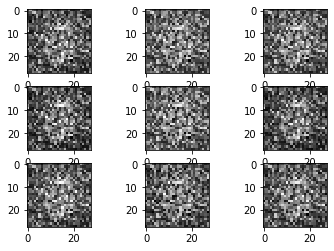

[20/4000]: loss_d: 0.795, loss_g: 2.084


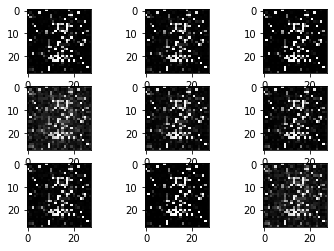

[40/4000]: loss_d: 0.675, loss_g: 2.640


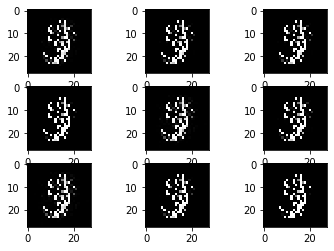

[60/4000]: loss_d: 0.315, loss_g: 5.604


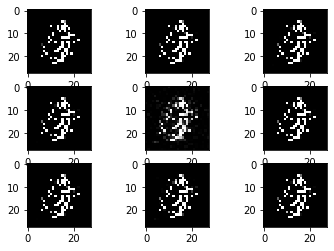

[80/4000]: loss_d: 0.063, loss_g: 9.389


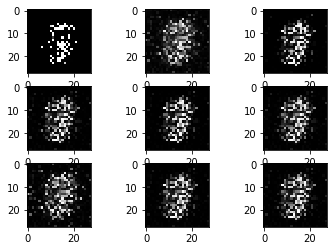

[100/4000]: loss_d: 0.295, loss_g: 6.470


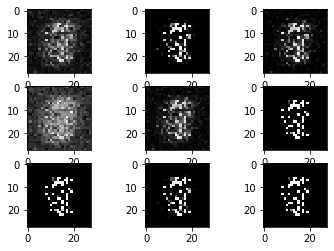

[120/4000]: loss_d: 0.966, loss_g: 13.910


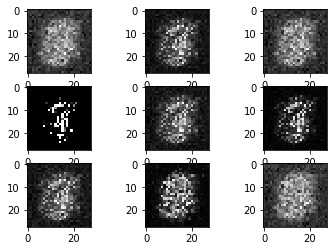

[140/4000]: loss_d: 1.158, loss_g: 3.044


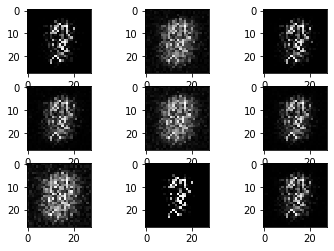

[160/4000]: loss_d: 0.766, loss_g: 4.351


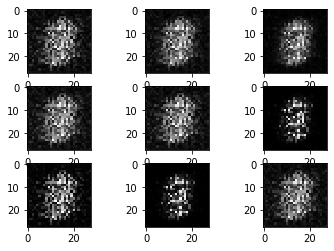

[180/4000]: loss_d: 0.912, loss_g: 3.633


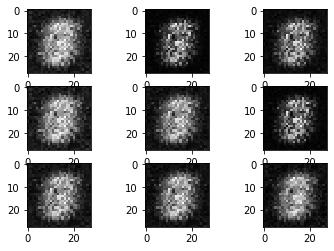

[200/4000]: loss_d: 0.701, loss_g: 3.303


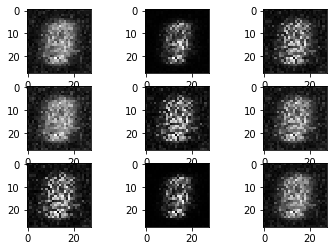

[220/4000]: loss_d: 0.555, loss_g: 4.479


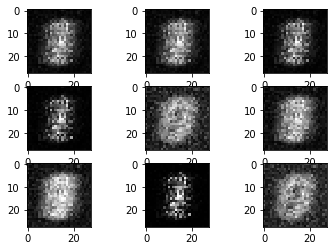

[240/4000]: loss_d: 0.615, loss_g: 2.874


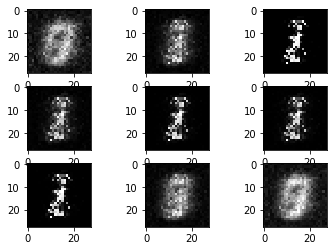

[260/4000]: loss_d: 0.447, loss_g: 3.174


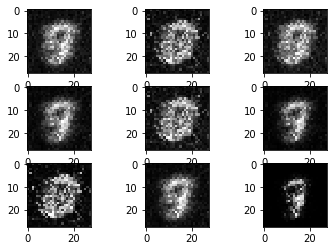

[280/4000]: loss_d: 0.572, loss_g: 2.877


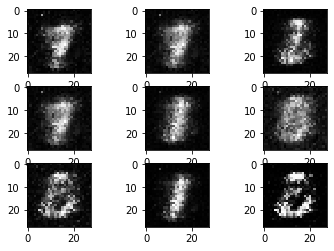

[300/4000]: loss_d: 0.537, loss_g: 3.205


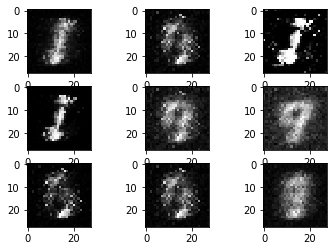

[320/4000]: loss_d: 0.429, loss_g: 2.980


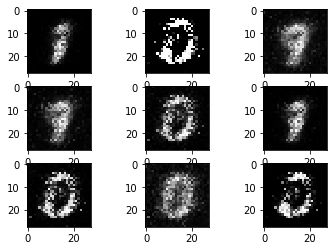

[340/4000]: loss_d: 0.684, loss_g: 3.178


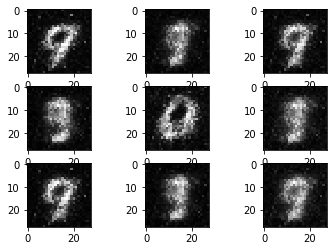

[360/4000]: loss_d: 0.323, loss_g: 3.504


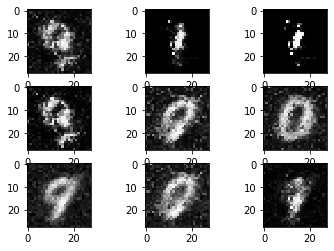

[380/4000]: loss_d: 0.460, loss_g: 3.114


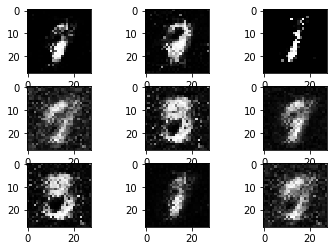

[400/4000]: loss_d: 0.265, loss_g: 3.426


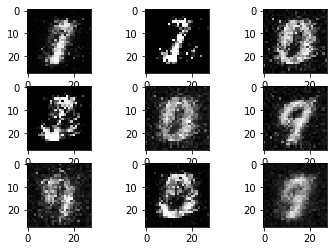

[420/4000]: loss_d: 0.525, loss_g: 3.359


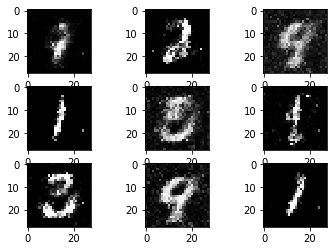

[440/4000]: loss_d: 0.380, loss_g: 3.403


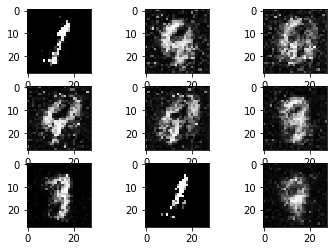

[460/4000]: loss_d: 0.488, loss_g: 2.949


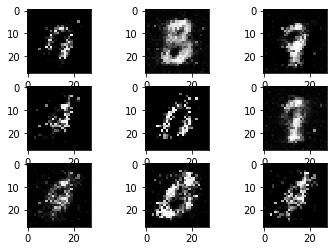

[480/4000]: loss_d: 0.380, loss_g: 3.472


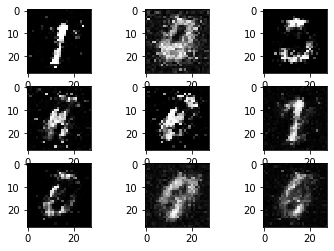

[500/4000]: loss_d: 0.575, loss_g: 2.992


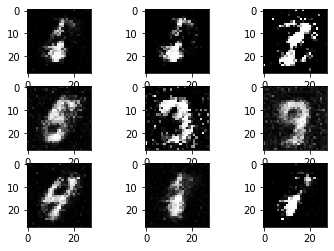

[520/4000]: loss_d: 0.531, loss_g: 2.673


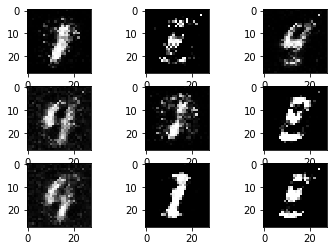

[540/4000]: loss_d: 0.448, loss_g: 3.320


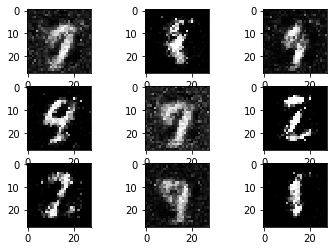

[560/4000]: loss_d: 0.379, loss_g: 3.110


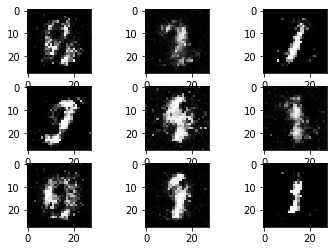

[580/4000]: loss_d: 0.543, loss_g: 2.820


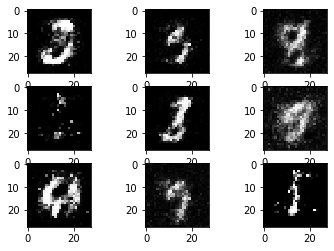

[600/4000]: loss_d: 0.624, loss_g: 2.426


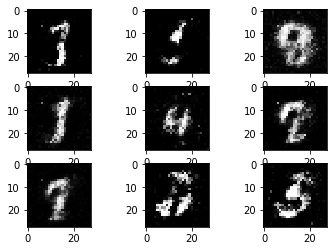

[620/4000]: loss_d: 0.602, loss_g: 2.230


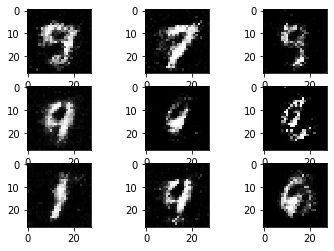

[640/4000]: loss_d: 0.548, loss_g: 2.413


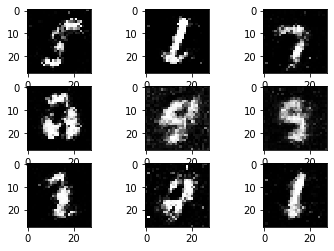

[660/4000]: loss_d: 0.673, loss_g: 2.434


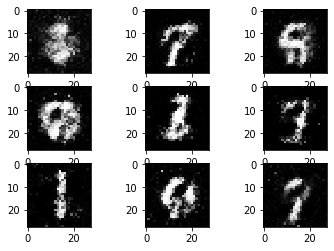

[680/4000]: loss_d: 0.479, loss_g: 2.507


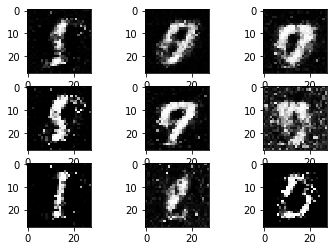

[700/4000]: loss_d: 0.494, loss_g: 3.026


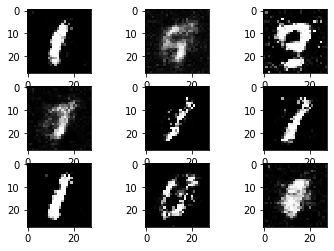

[720/4000]: loss_d: 0.473, loss_g: 2.943


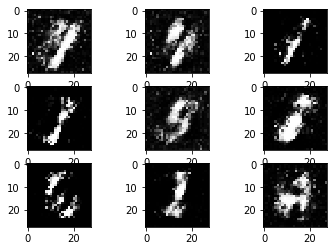

[740/4000]: loss_d: 0.598, loss_g: 2.614


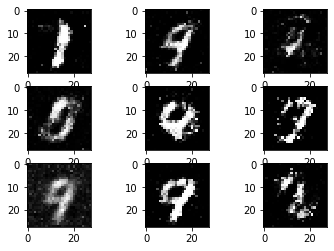

[760/4000]: loss_d: 0.484, loss_g: 2.541


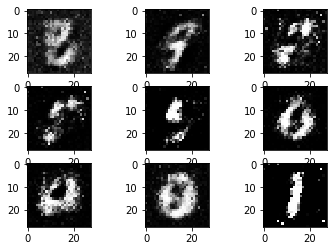

[780/4000]: loss_d: 0.852, loss_g: 2.350


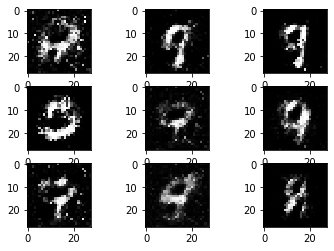

[800/4000]: loss_d: 0.550, loss_g: 2.564


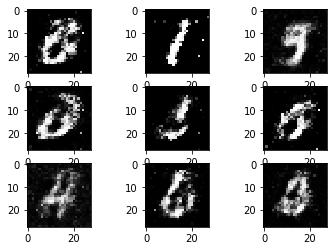

[820/4000]: loss_d: 0.566, loss_g: 2.795


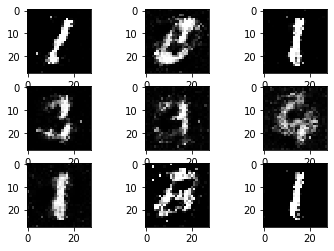

[840/4000]: loss_d: 0.538, loss_g: 2.360


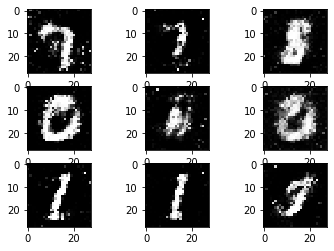

[860/4000]: loss_d: 0.657, loss_g: 2.272


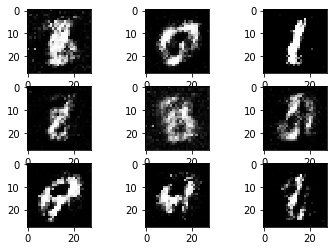

[880/4000]: loss_d: 0.856, loss_g: 1.960


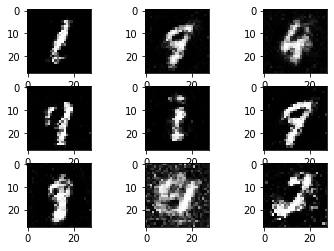

[900/4000]: loss_d: 0.819, loss_g: 2.057


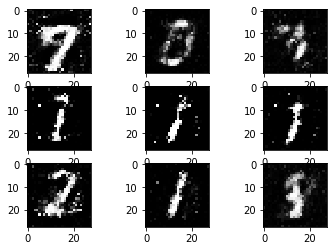

[920/4000]: loss_d: 0.695, loss_g: 1.952


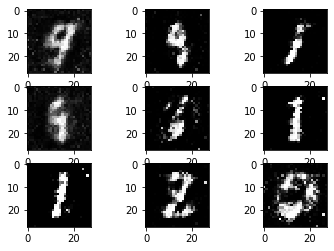

[940/4000]: loss_d: 0.849, loss_g: 1.987


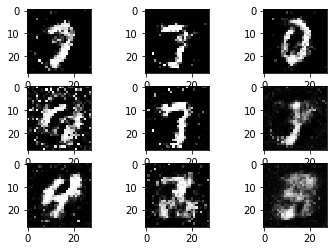

[960/4000]: loss_d: 0.502, loss_g: 2.773


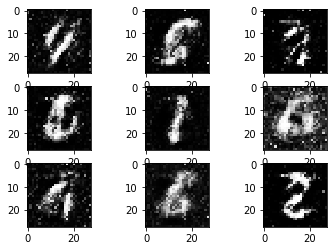

[980/4000]: loss_d: 0.713, loss_g: 2.359


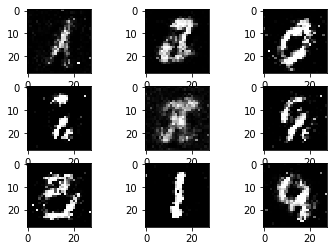

[1000/4000]: loss_d: 0.894, loss_g: 1.830


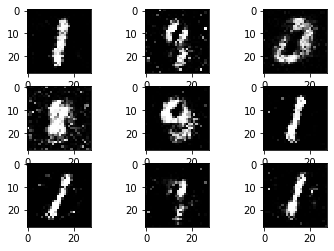

[1020/4000]: loss_d: 0.503, loss_g: 2.598


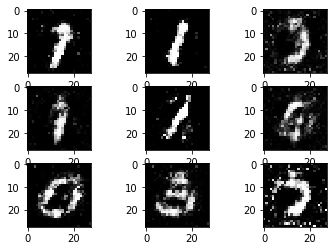

[1040/4000]: loss_d: 0.706, loss_g: 2.276


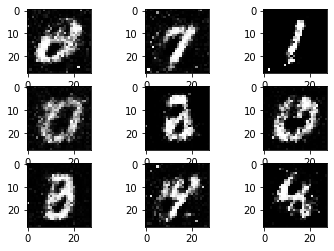

[1060/4000]: loss_d: 0.665, loss_g: 2.377


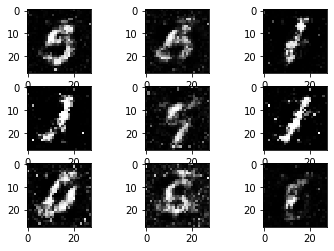

[1080/4000]: loss_d: 0.555, loss_g: 2.636


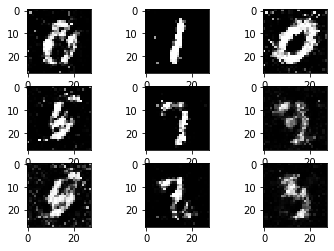

[1100/4000]: loss_d: 0.535, loss_g: 2.505


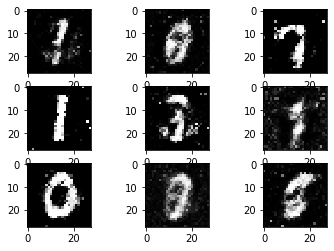

[1120/4000]: loss_d: 0.670, loss_g: 2.317


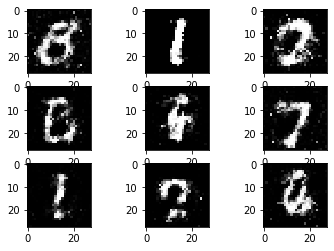

[1140/4000]: loss_d: 0.787, loss_g: 1.791


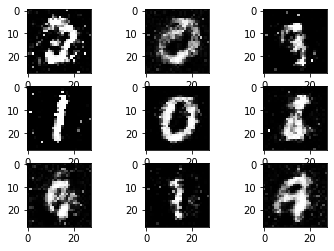

[1160/4000]: loss_d: 0.578, loss_g: 2.316


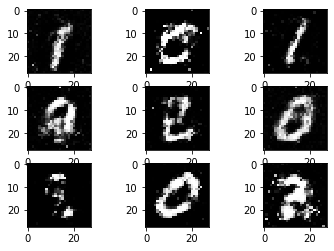

[1180/4000]: loss_d: 0.706, loss_g: 2.284


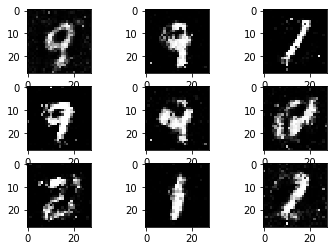

[1200/4000]: loss_d: 1.088, loss_g: 1.489


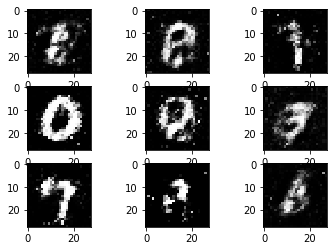

[1220/4000]: loss_d: 0.710, loss_g: 2.135


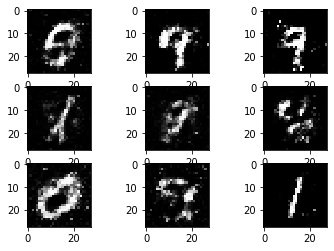

[1240/4000]: loss_d: 0.610, loss_g: 2.292


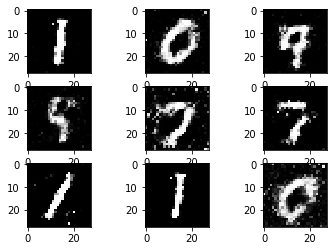

[1260/4000]: loss_d: 0.765, loss_g: 2.022


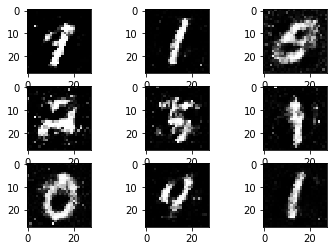

[1280/4000]: loss_d: 0.807, loss_g: 2.108


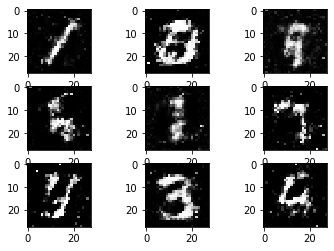

[1300/4000]: loss_d: 0.696, loss_g: 2.378


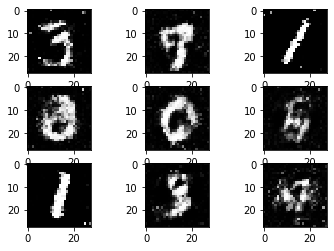

[1320/4000]: loss_d: 0.617, loss_g: 2.759


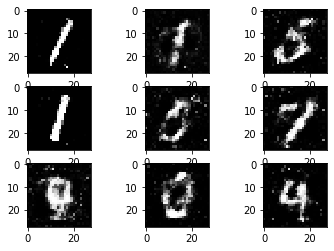

[1340/4000]: loss_d: 0.597, loss_g: 2.736


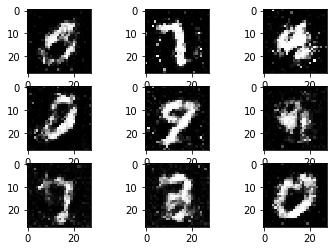

[1360/4000]: loss_d: 0.623, loss_g: 2.313


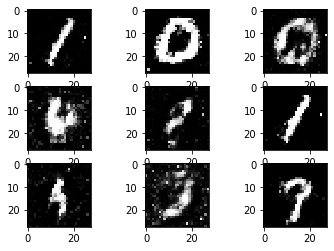

[1380/4000]: loss_d: 0.642, loss_g: 2.563


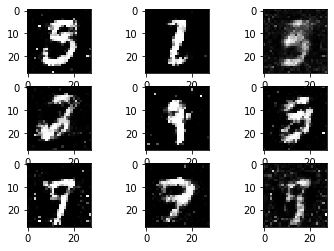

[1400/4000]: loss_d: 0.753, loss_g: 2.266


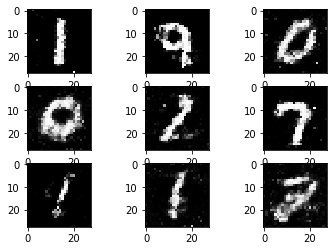

[1420/4000]: loss_d: 0.760, loss_g: 2.271


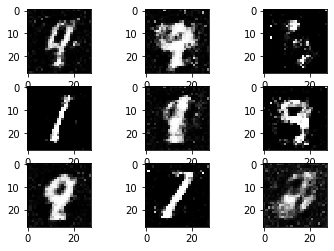

[1440/4000]: loss_d: 0.706, loss_g: 2.152


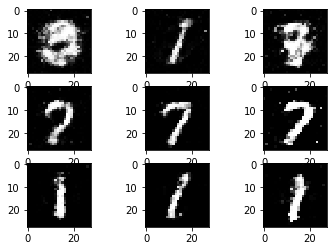

[1460/4000]: loss_d: 0.620, loss_g: 2.451


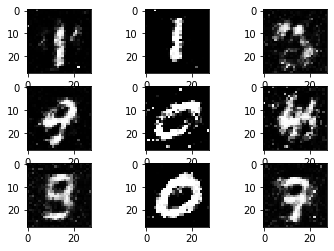

[1480/4000]: loss_d: 0.663, loss_g: 2.506


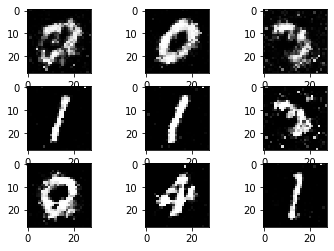

[1500/4000]: loss_d: 0.633, loss_g: 2.489


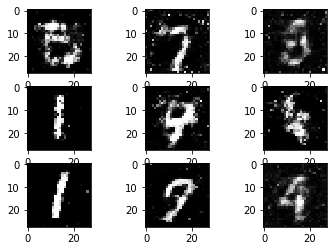

[1520/4000]: loss_d: 0.811, loss_g: 2.269


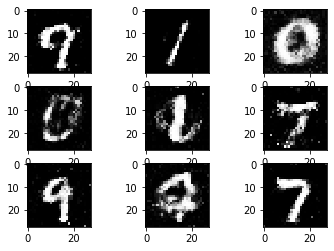

[1540/4000]: loss_d: 0.536, loss_g: 2.465


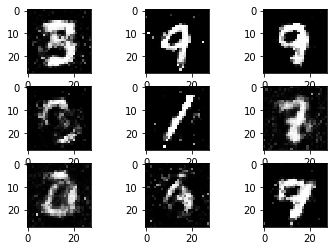

[1560/4000]: loss_d: 0.620, loss_g: 2.452


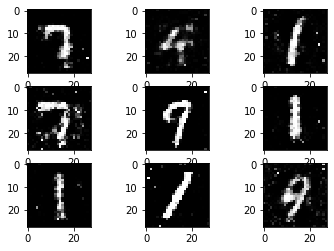

[1580/4000]: loss_d: 0.742, loss_g: 2.261


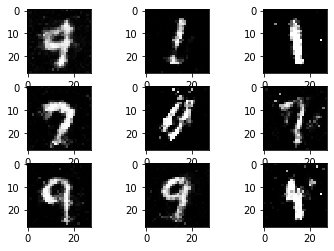

[1600/4000]: loss_d: 0.750, loss_g: 2.105


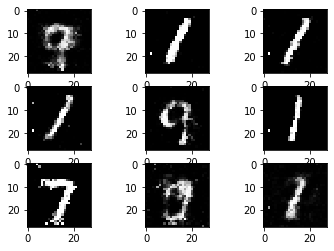

[1620/4000]: loss_d: 0.666, loss_g: 2.392


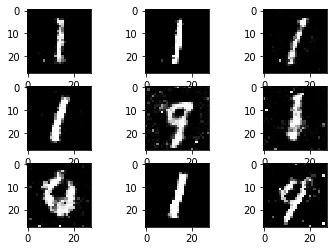

[1640/4000]: loss_d: 0.576, loss_g: 2.422


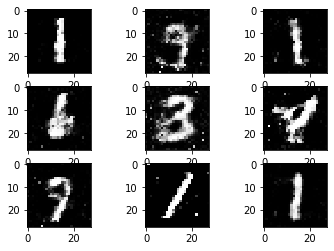

[1660/4000]: loss_d: 0.541, loss_g: 2.539


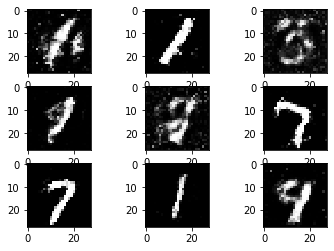

[1680/4000]: loss_d: 0.531, loss_g: 3.009


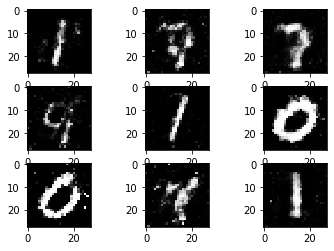

[1700/4000]: loss_d: 0.528, loss_g: 2.735


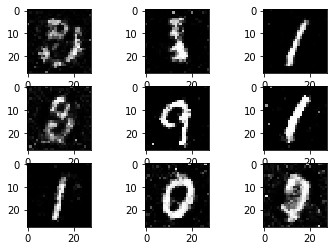

[1720/4000]: loss_d: 0.582, loss_g: 2.436


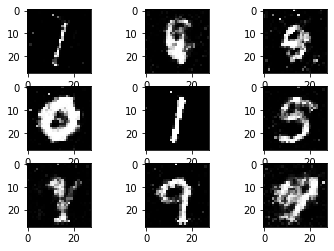

[1740/4000]: loss_d: 0.636, loss_g: 2.154


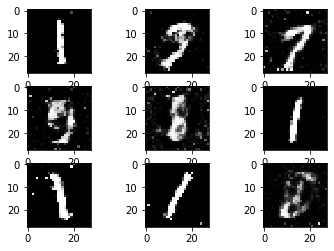

[1760/4000]: loss_d: 0.590, loss_g: 2.199


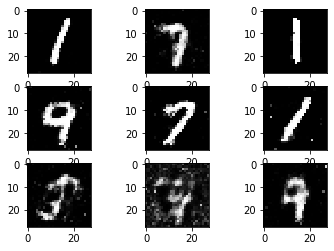

[1780/4000]: loss_d: 0.526, loss_g: 2.916


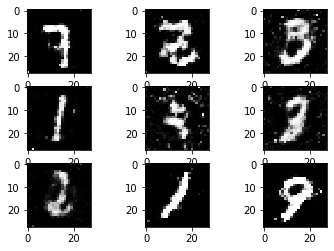

[1800/4000]: loss_d: 0.486, loss_g: 2.729


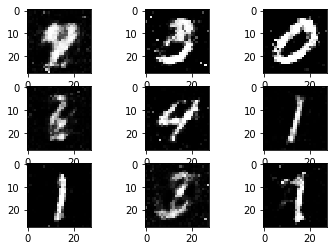

[1820/4000]: loss_d: 0.505, loss_g: 2.856


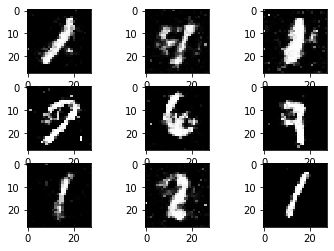

[1840/4000]: loss_d: 0.486, loss_g: 2.896


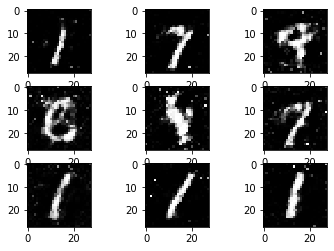

[1860/4000]: loss_d: 0.601, loss_g: 2.610


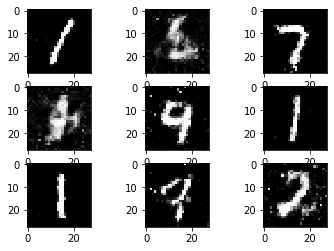

[1880/4000]: loss_d: 0.508, loss_g: 3.170


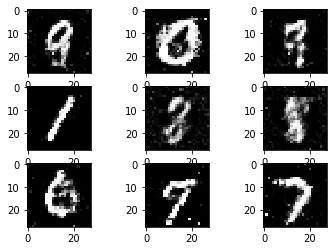

[1900/4000]: loss_d: 0.456, loss_g: 2.737


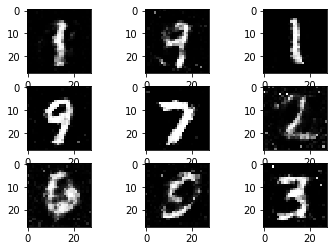

[1920/4000]: loss_d: 0.559, loss_g: 2.751


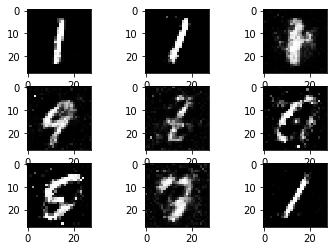

[1940/4000]: loss_d: 0.624, loss_g: 2.325


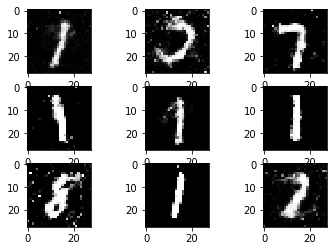

[1960/4000]: loss_d: 0.448, loss_g: 2.926


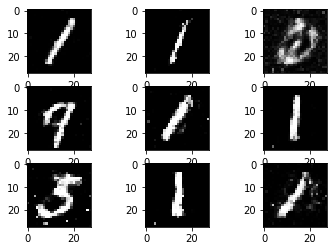

[1980/4000]: loss_d: 0.499, loss_g: 2.769


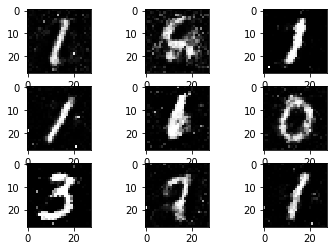

[2000/4000]: loss_d: 0.480, loss_g: 2.749


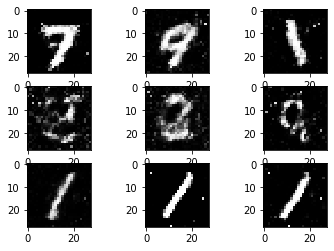

[2020/4000]: loss_d: 0.588, loss_g: 2.632


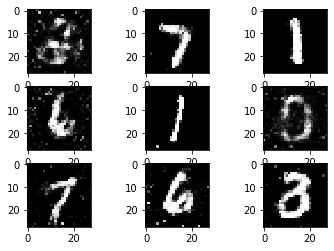

[2040/4000]: loss_d: 0.529, loss_g: 2.587


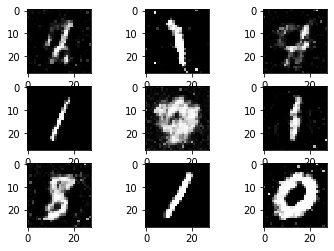

[2060/4000]: loss_d: 0.517, loss_g: 2.759


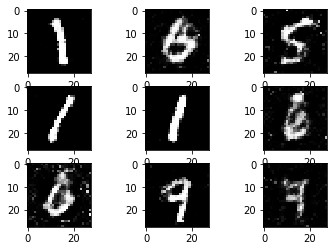

[2080/4000]: loss_d: 0.535, loss_g: 3.015


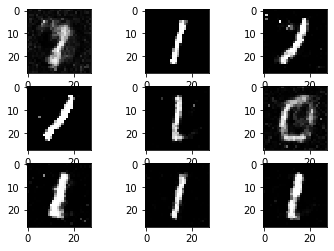

[2100/4000]: loss_d: 0.434, loss_g: 3.442


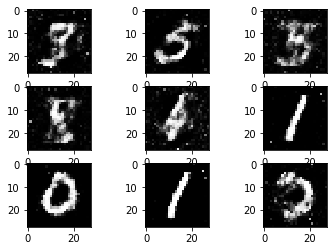

[2120/4000]: loss_d: 0.491, loss_g: 2.990


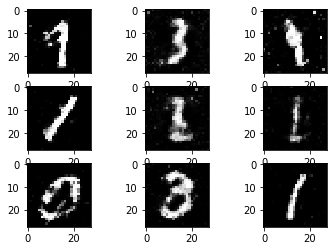

[2140/4000]: loss_d: 0.420, loss_g: 3.339


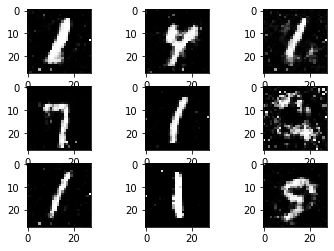

[2160/4000]: loss_d: 0.515, loss_g: 2.837


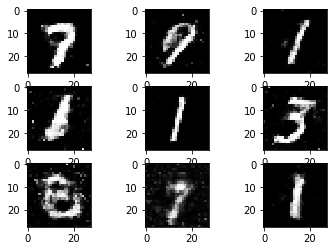

[2180/4000]: loss_d: 0.500, loss_g: 2.421


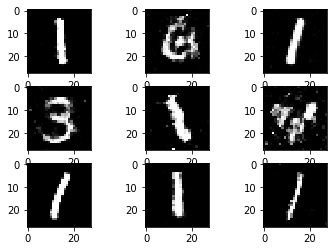

[2200/4000]: loss_d: 0.400, loss_g: 3.570


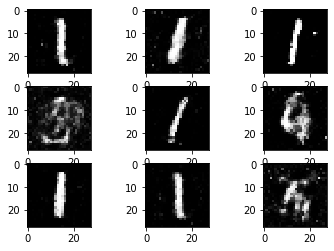

[2220/4000]: loss_d: 0.446, loss_g: 3.146


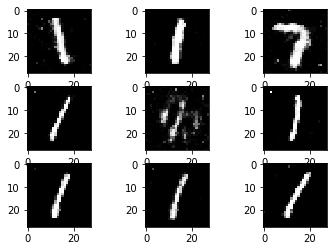

[2240/4000]: loss_d: 0.383, loss_g: 3.033


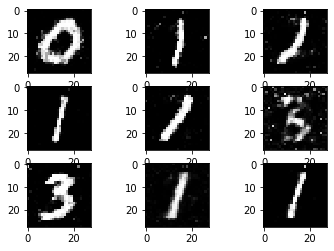

[2260/4000]: loss_d: 0.502, loss_g: 3.173


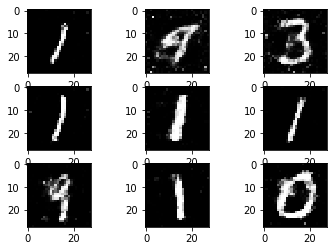

[2280/4000]: loss_d: 0.379, loss_g: 3.131


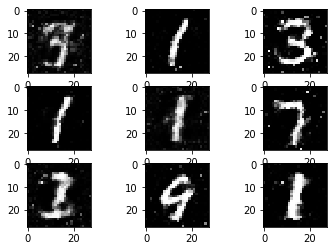

[2300/4000]: loss_d: 0.480, loss_g: 3.293


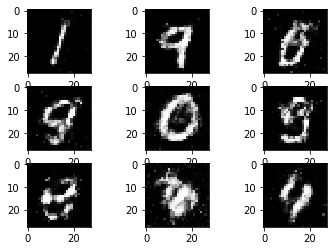

[2320/4000]: loss_d: 0.403, loss_g: 3.480


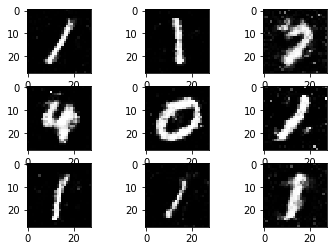

[2340/4000]: loss_d: 0.574, loss_g: 2.916


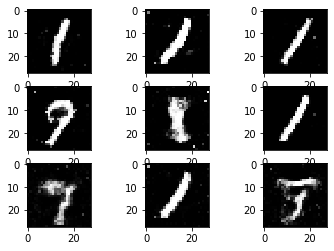

[2360/4000]: loss_d: 0.456, loss_g: 2.987


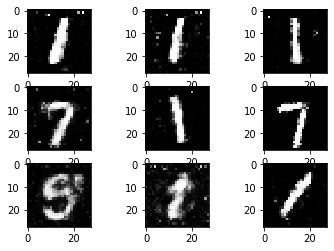

[2380/4000]: loss_d: 0.487, loss_g: 3.152


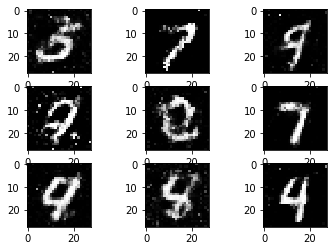

[2400/4000]: loss_d: 0.417, loss_g: 2.928


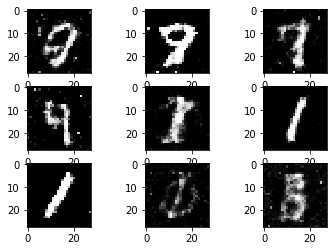

[2420/4000]: loss_d: 0.399, loss_g: 3.543


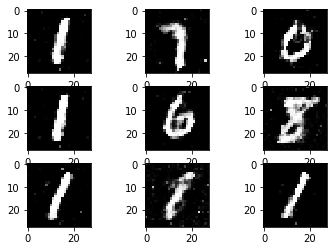

[2440/4000]: loss_d: 0.456, loss_g: 2.892


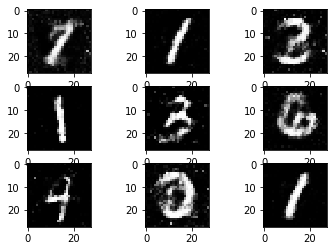

[2460/4000]: loss_d: 0.489, loss_g: 3.202


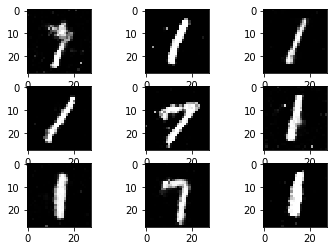

[2480/4000]: loss_d: 0.365, loss_g: 3.397


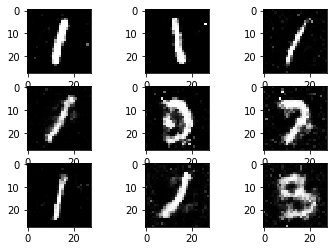

[2500/4000]: loss_d: 0.350, loss_g: 3.251


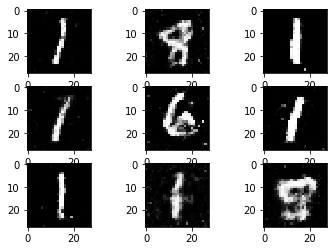

[2520/4000]: loss_d: 0.443, loss_g: 3.346


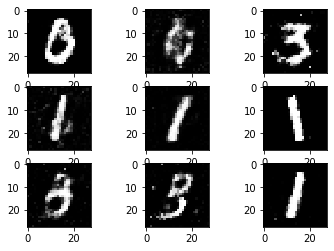

[2540/4000]: loss_d: 0.399, loss_g: 3.176


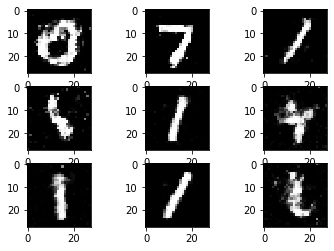

[2560/4000]: loss_d: 0.372, loss_g: 3.332


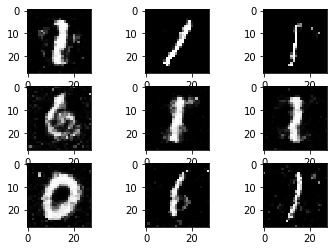

[2580/4000]: loss_d: 0.431, loss_g: 3.776


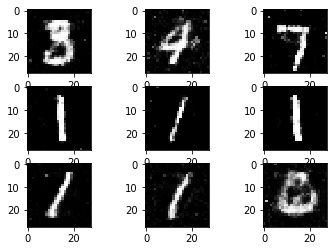

[2600/4000]: loss_d: 0.427, loss_g: 2.969


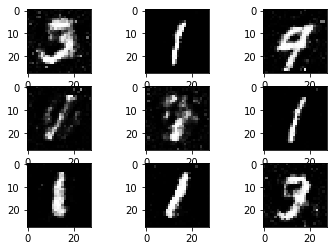

[2620/4000]: loss_d: 0.395, loss_g: 3.175


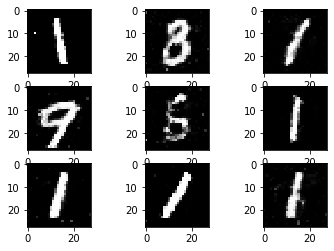

[2640/4000]: loss_d: 0.428, loss_g: 3.163


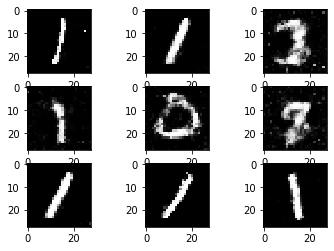

[2660/4000]: loss_d: 0.437, loss_g: 3.083


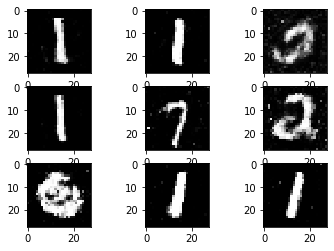

[2680/4000]: loss_d: 0.367, loss_g: 3.095


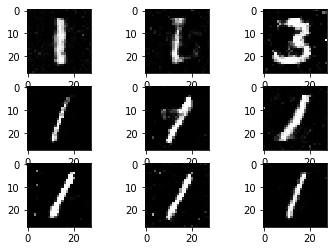

[2700/4000]: loss_d: 0.391, loss_g: 3.532


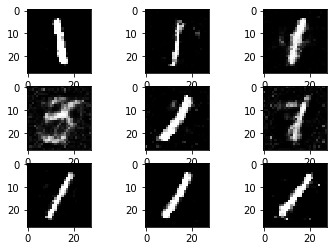

[2720/4000]: loss_d: 0.350, loss_g: 3.193


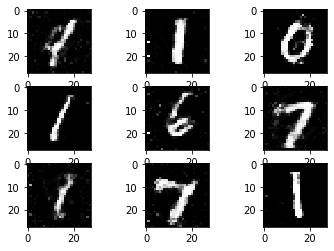

[2740/4000]: loss_d: 0.391, loss_g: 3.037


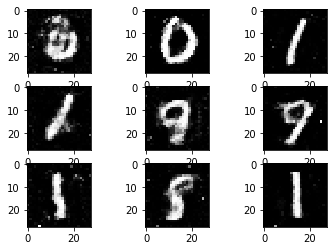

[2760/4000]: loss_d: 0.363, loss_g: 3.326


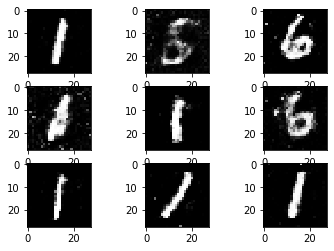

[2780/4000]: loss_d: 0.451, loss_g: 3.048


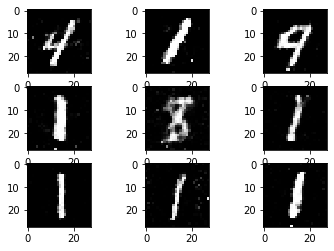

[2800/4000]: loss_d: 0.415, loss_g: 3.130


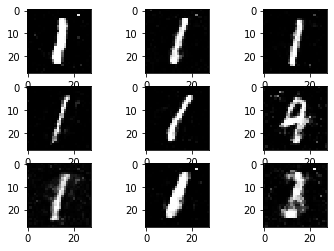

[2820/4000]: loss_d: 0.405, loss_g: 3.187


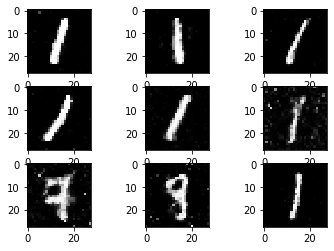

[2840/4000]: loss_d: 0.348, loss_g: 3.200


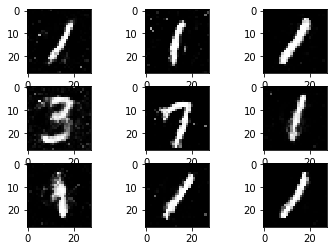

[2860/4000]: loss_d: 0.341, loss_g: 3.373


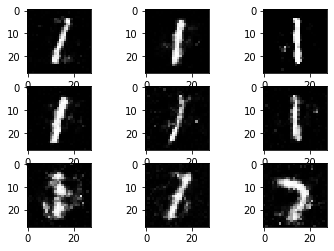

[2880/4000]: loss_d: 0.396, loss_g: 3.369


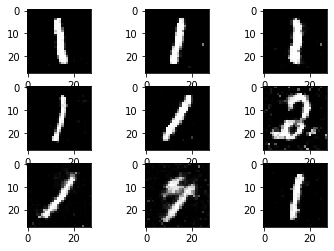

[2900/4000]: loss_d: 0.401, loss_g: 3.188


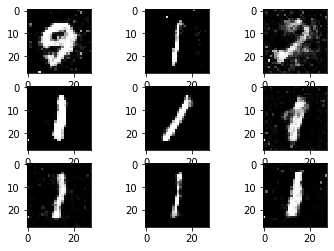

[2920/4000]: loss_d: 0.376, loss_g: 3.143


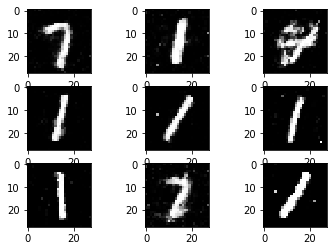

[2940/4000]: loss_d: 0.383, loss_g: 3.086


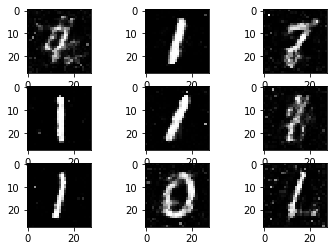

[2960/4000]: loss_d: 0.334, loss_g: 3.362


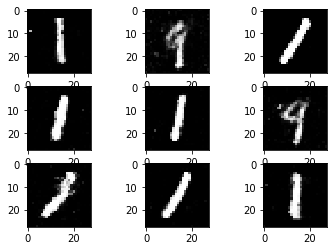

[2980/4000]: loss_d: 0.409, loss_g: 3.350


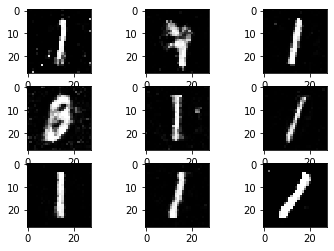

[3000/4000]: loss_d: 0.360, loss_g: 3.207


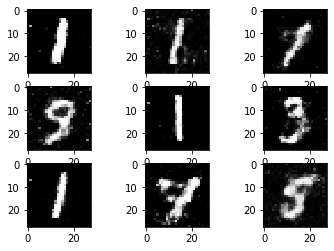

[3020/4000]: loss_d: 0.389, loss_g: 3.606


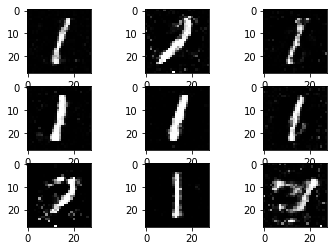

[3040/4000]: loss_d: 0.441, loss_g: 3.077


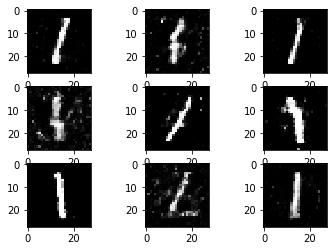

[3060/4000]: loss_d: 0.350, loss_g: 3.067


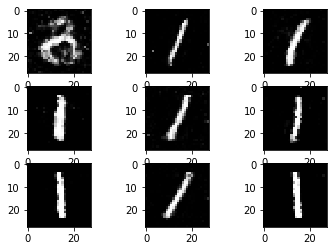

[3080/4000]: loss_d: 0.415, loss_g: 2.850


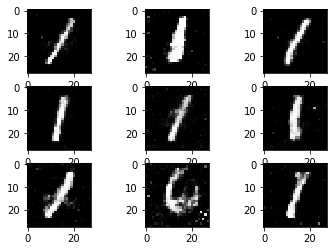

[3100/4000]: loss_d: 0.391, loss_g: 3.009


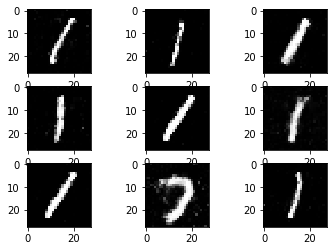

[3120/4000]: loss_d: 0.409, loss_g: 3.140


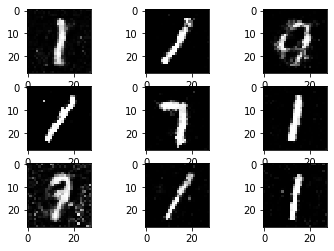

[3140/4000]: loss_d: 0.358, loss_g: 3.432


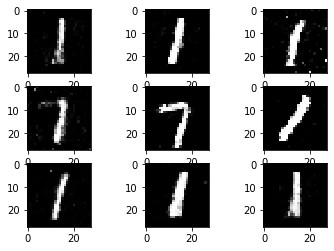

[3160/4000]: loss_d: 0.342, loss_g: 3.064


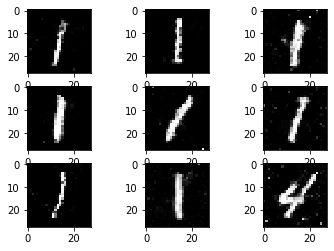

[3180/4000]: loss_d: 0.422, loss_g: 3.128


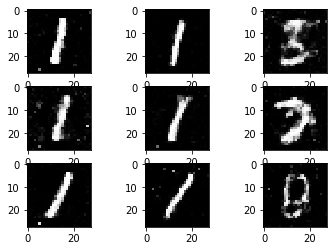

[3200/4000]: loss_d: 0.363, loss_g: 3.106


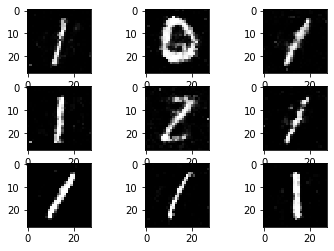

[3220/4000]: loss_d: 0.420, loss_g: 3.129


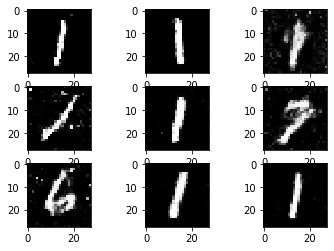

[3240/4000]: loss_d: 0.342, loss_g: 3.789


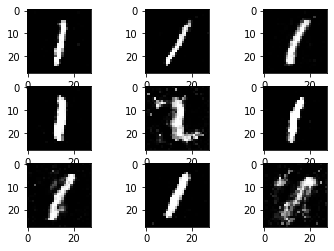

[3260/4000]: loss_d: 0.351, loss_g: 3.507


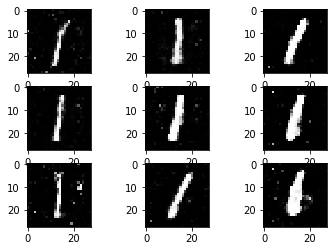

[3280/4000]: loss_d: 0.395, loss_g: 3.061


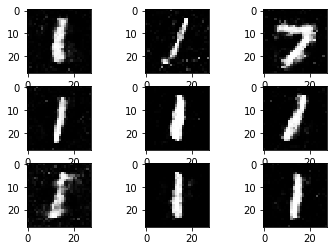

[3300/4000]: loss_d: 0.307, loss_g: 3.599


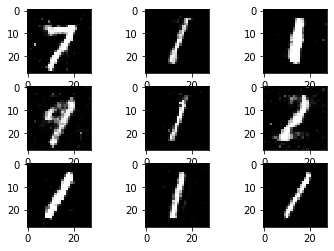

[3320/4000]: loss_d: 0.351, loss_g: 3.416


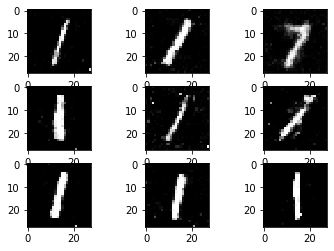

[3340/4000]: loss_d: 0.355, loss_g: 3.357


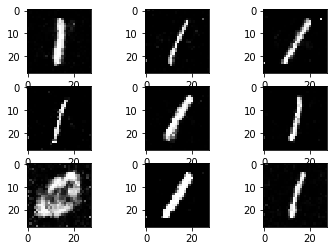

[3360/4000]: loss_d: 0.365, loss_g: 3.305


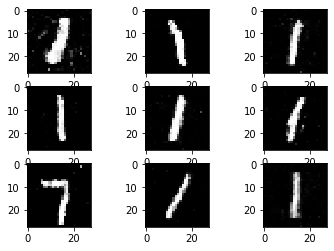

[3380/4000]: loss_d: 0.380, loss_g: 3.150


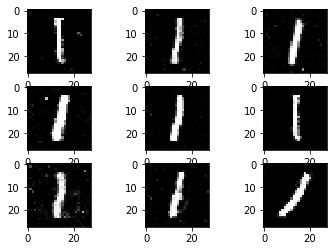

[3400/4000]: loss_d: 0.485, loss_g: 3.194


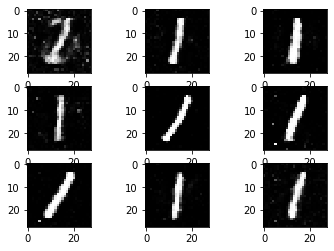

[3420/4000]: loss_d: 0.407, loss_g: 3.407


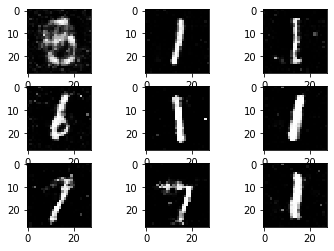

[3440/4000]: loss_d: 0.328, loss_g: 3.444


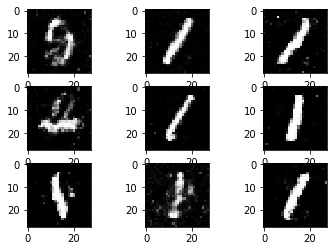

[3460/4000]: loss_d: 0.360, loss_g: 3.171


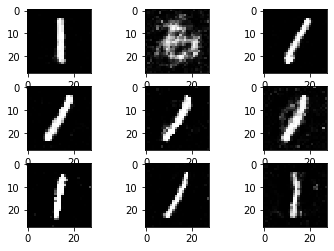

[3480/4000]: loss_d: 0.370, loss_g: 3.517


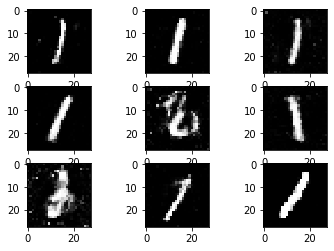

[3500/4000]: loss_d: 0.307, loss_g: 3.612


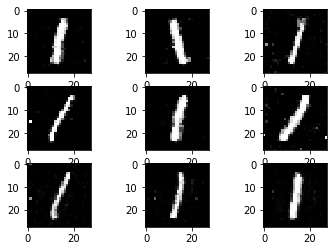

[3520/4000]: loss_d: 0.351, loss_g: 3.226


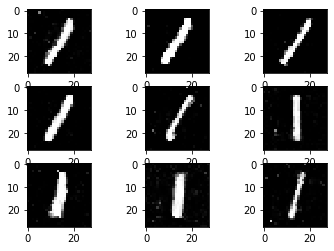

[3540/4000]: loss_d: 0.336, loss_g: 3.237


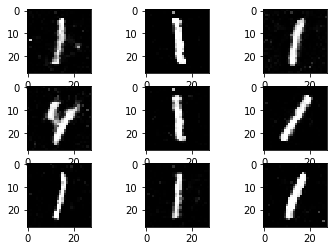

[3560/4000]: loss_d: 0.383, loss_g: 3.124


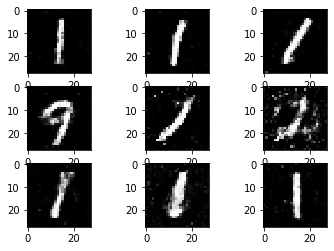

[3580/4000]: loss_d: 0.381, loss_g: 3.344


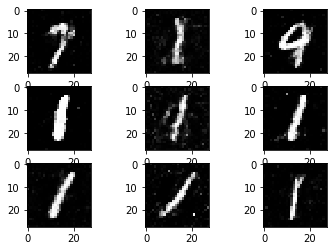

[3600/4000]: loss_d: 0.357, loss_g: 3.541


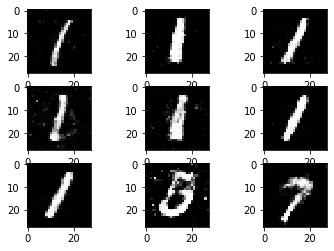

[3620/4000]: loss_d: 0.352, loss_g: 3.227


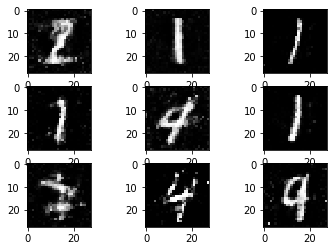

[3640/4000]: loss_d: 0.364, loss_g: 3.514


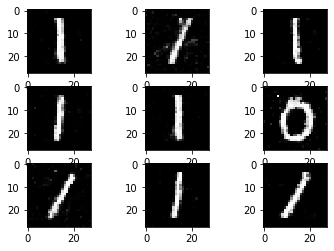

[3660/4000]: loss_d: 0.380, loss_g: 3.480


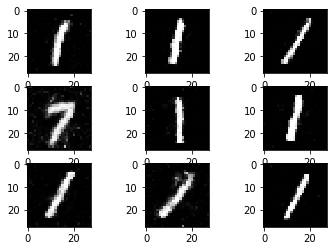

[3680/4000]: loss_d: 0.314, loss_g: 3.555


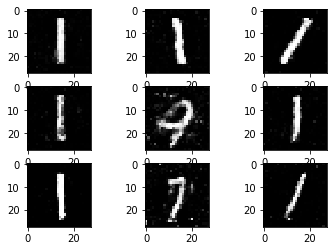

[3700/4000]: loss_d: 0.374, loss_g: 3.282


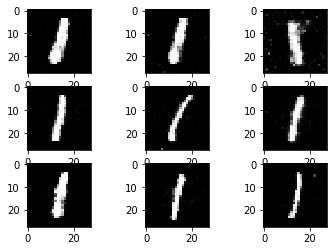

[3720/4000]: loss_d: 0.451, loss_g: 3.484


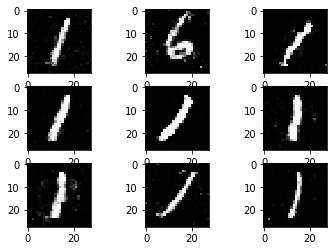

[3740/4000]: loss_d: 0.309, loss_g: 3.130


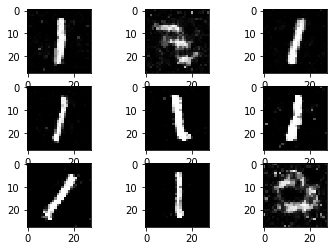

[3760/4000]: loss_d: 0.389, loss_g: 3.345


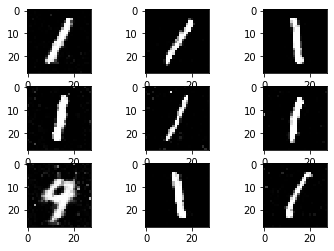

[3780/4000]: loss_d: 0.357, loss_g: 3.126


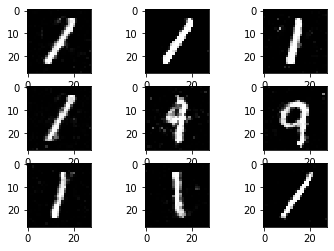

[3800/4000]: loss_d: 0.389, loss_g: 3.265


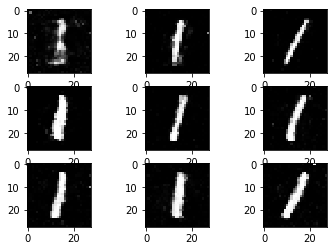

[3820/4000]: loss_d: 0.335, loss_g: 3.205


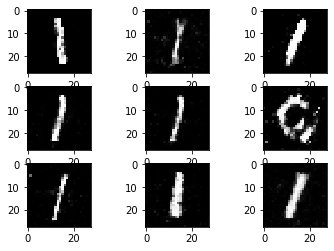

[3840/4000]: loss_d: 0.362, loss_g: 3.379


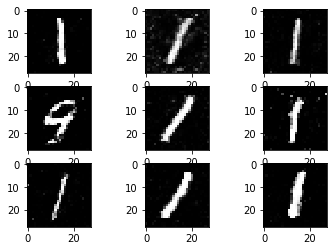

[3860/4000]: loss_d: 0.374, loss_g: 3.695


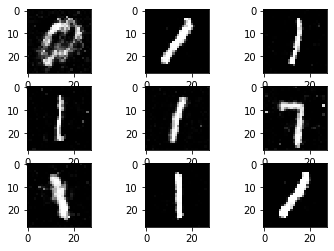

[3880/4000]: loss_d: 0.351, loss_g: 3.373


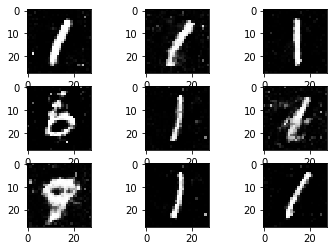

[3900/4000]: loss_d: 0.283, loss_g: 3.202


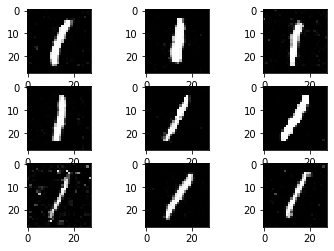

[3920/4000]: loss_d: 0.397, loss_g: 3.410


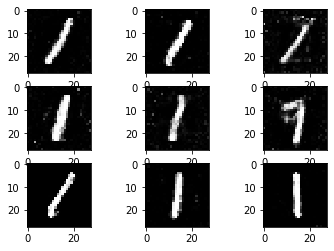

[3940/4000]: loss_d: 0.387, loss_g: 3.488


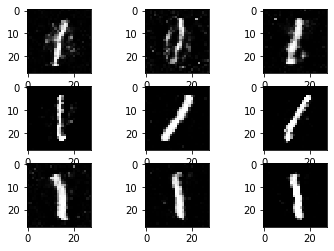

[3960/4000]: loss_d: 0.384, loss_g: 3.170


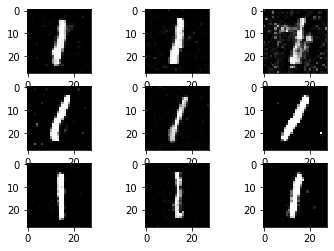

[3980/4000]: loss_d: 0.335, loss_g: 3.310


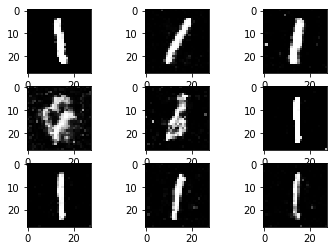

[4000/4000]: loss_d: 0.400, loss_g: 2.916


In [178]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 4000 #4000
print_stride = 20

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x, penalty = 'pair_lipschitz', alpha = alpha))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

## Relative Discriminator

In [179]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class RelDiscriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(RelDiscriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc4(x) # needs linear output

In [180]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
RD = RelDiscriminator(mnist_dim).to(device)

In [181]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
RD_optimizer = optim.Adam(RD.parameters(), lr = lr)

In [182]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [183]:
RD

RelDiscriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [184]:
# TAKEN FROM ANOTEHR

def RD_train(x_r):
    RD.zero_grad()
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))

    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)

    sout = torch.sigmoid(RD(x_r) - RD(x_f))# where C is some discrim with LINEAR OUTPUT
    RD_loss = -torch.mean(torch.log(sout))
    
    RD_loss.backward() #retain_graph=True
    RD_optimizer.step()
        
    return  RD_loss.data.item()

# For paper recreation
def RD_G_train(x_r):
    G.zero_grad()
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))


    # My code
    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)
    
    sout = torch.sigmoid(RD(x_f) - RD(x_r))

    G_loss = -torch.mean(torch.log(sout))
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

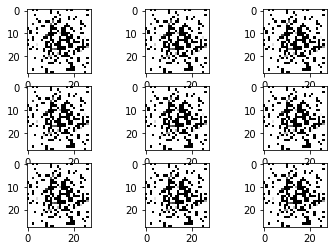

[20/2000]: loss_d: 0.000, loss_g: 26.166


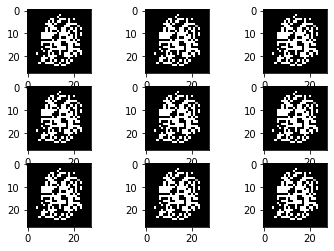

[40/2000]: loss_d: 0.000, loss_g: 11.022


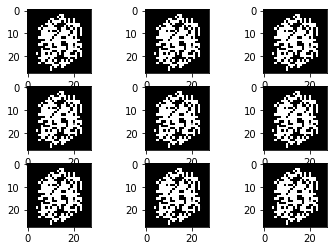

[60/2000]: loss_d: 0.000, loss_g: 13.369


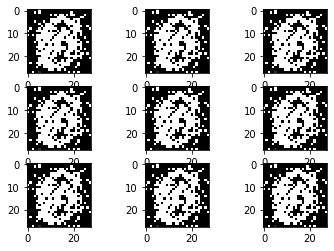

[80/2000]: loss_d: 0.000, loss_g: 25.989


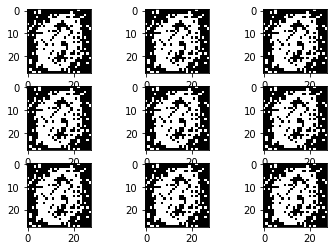

[100/2000]: loss_d: 0.000, loss_g: 21.599


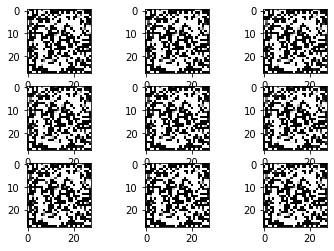

[120/2000]: loss_d: 0.021, loss_g: 19.567


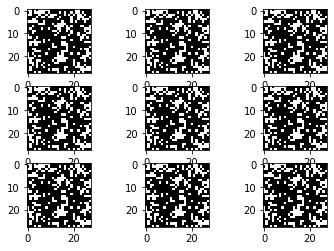

[140/2000]: loss_d: 0.000, loss_g: 22.438


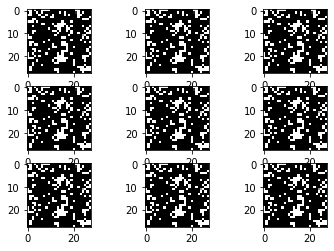

[160/2000]: loss_d: 0.000, loss_g: 20.545


C:\Users\Alex\Anaconda3\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\Alex\Anaconda3\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\Alex\Anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Alex\Anaconda3\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\Alex\Anaconda3\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


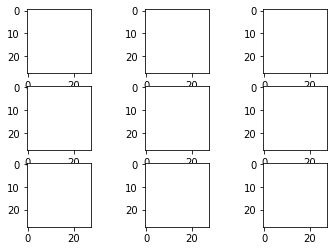

[180/2000]: loss_d: nan, loss_g: nan


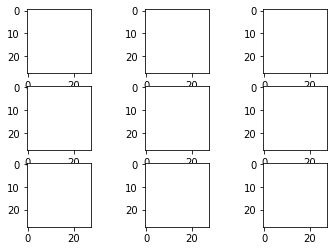

[200/2000]: loss_d: nan, loss_g: nan


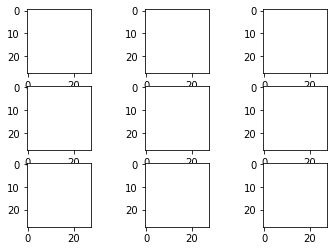

[220/2000]: loss_d: nan, loss_g: nan


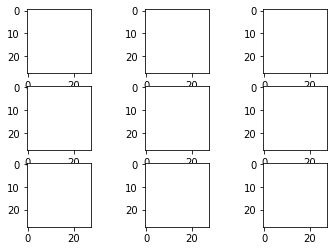

[240/2000]: loss_d: nan, loss_g: nan


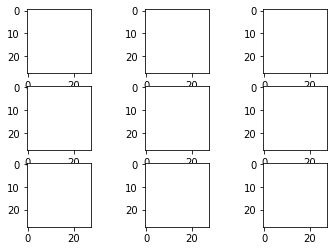

[260/2000]: loss_d: nan, loss_g: nan


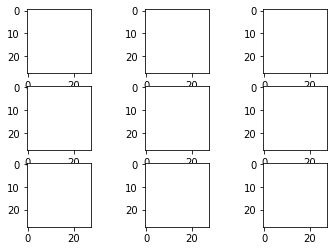

[280/2000]: loss_d: nan, loss_g: nan


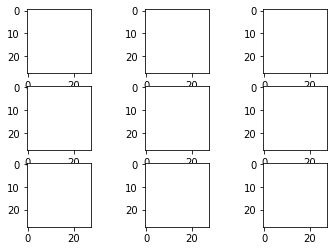

[300/2000]: loss_d: nan, loss_g: nan


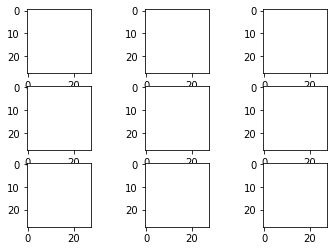

[320/2000]: loss_d: nan, loss_g: nan


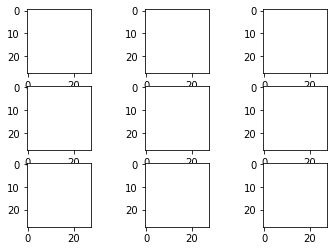

[340/2000]: loss_d: nan, loss_g: nan


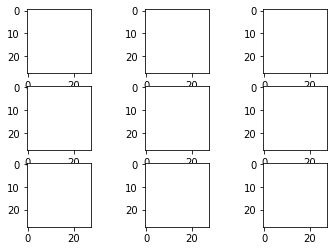

[360/2000]: loss_d: nan, loss_g: nan


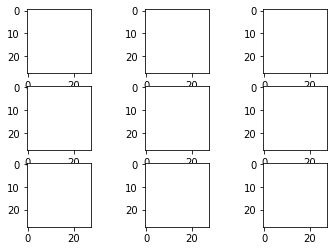

[380/2000]: loss_d: nan, loss_g: nan


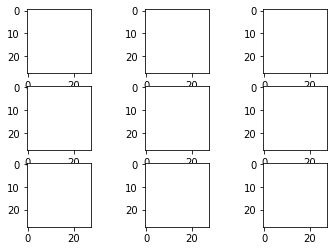

[400/2000]: loss_d: nan, loss_g: nan


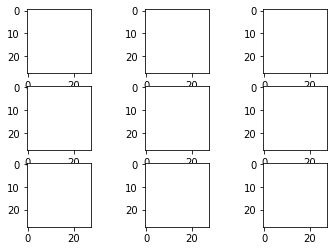

[420/2000]: loss_d: nan, loss_g: nan


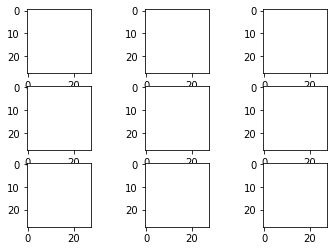

[440/2000]: loss_d: nan, loss_g: nan


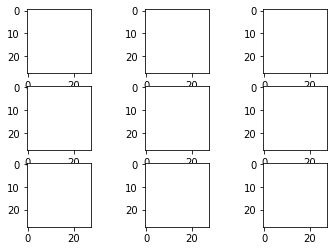

[460/2000]: loss_d: nan, loss_g: nan


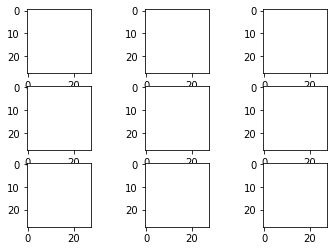

[480/2000]: loss_d: nan, loss_g: nan


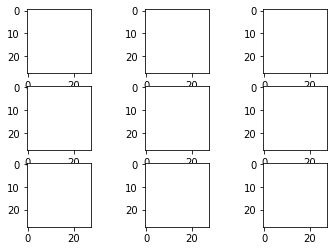

[500/2000]: loss_d: nan, loss_g: nan


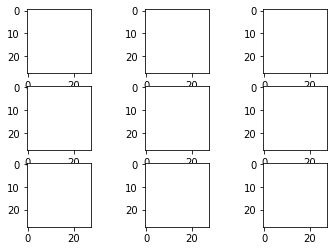

[520/2000]: loss_d: nan, loss_g: nan


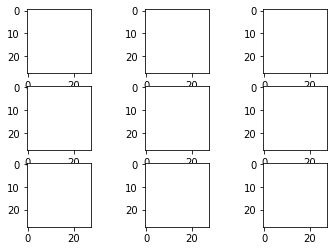

[540/2000]: loss_d: nan, loss_g: nan


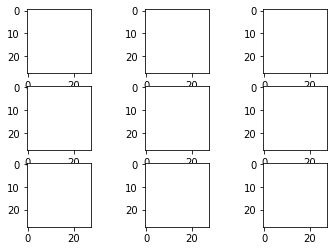

[560/2000]: loss_d: nan, loss_g: nan


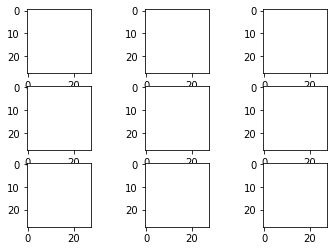

[580/2000]: loss_d: nan, loss_g: nan


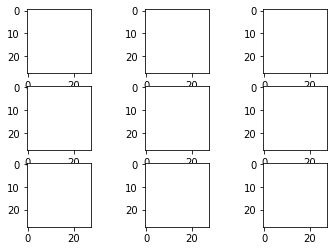

[600/2000]: loss_d: nan, loss_g: nan


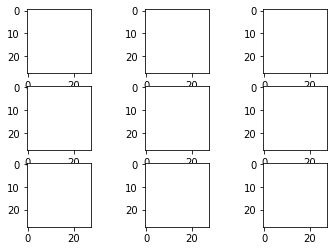

[620/2000]: loss_d: nan, loss_g: nan


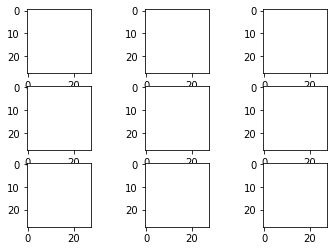

[640/2000]: loss_d: nan, loss_g: nan


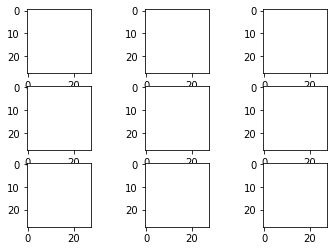

[660/2000]: loss_d: nan, loss_g: nan


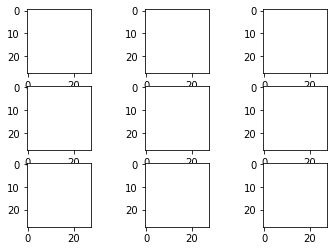

[680/2000]: loss_d: nan, loss_g: nan


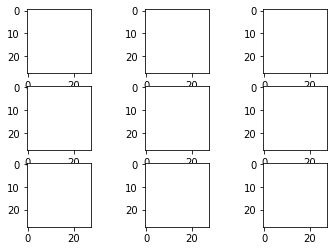

[700/2000]: loss_d: nan, loss_g: nan


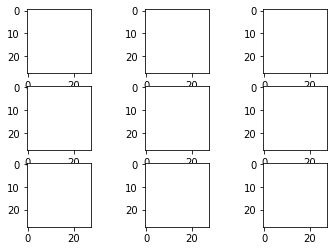

[720/2000]: loss_d: nan, loss_g: nan


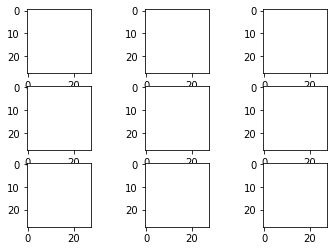

[740/2000]: loss_d: nan, loss_g: nan


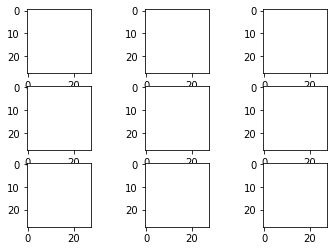

[760/2000]: loss_d: nan, loss_g: nan


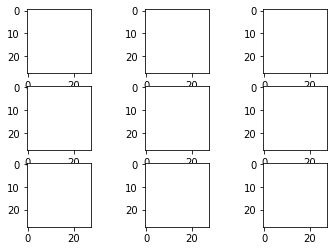

[780/2000]: loss_d: nan, loss_g: nan


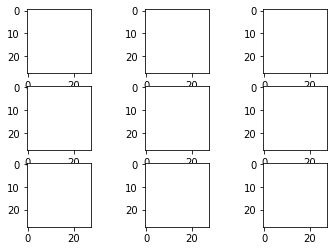

[800/2000]: loss_d: nan, loss_g: nan


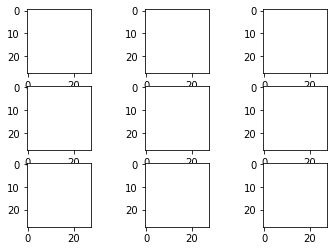

[820/2000]: loss_d: nan, loss_g: nan


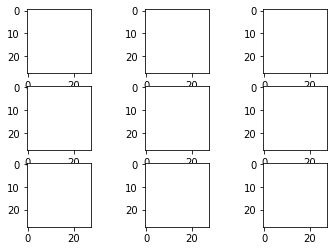

[840/2000]: loss_d: nan, loss_g: nan


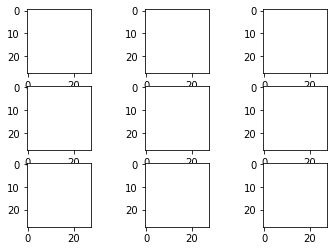

[860/2000]: loss_d: nan, loss_g: nan


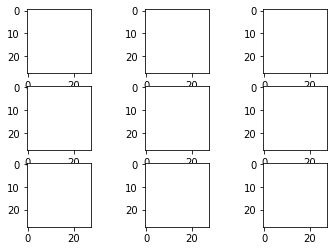

[880/2000]: loss_d: nan, loss_g: nan


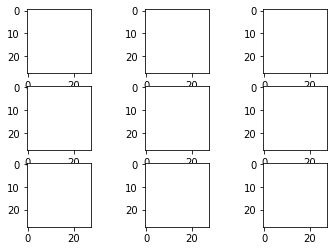

[900/2000]: loss_d: nan, loss_g: nan


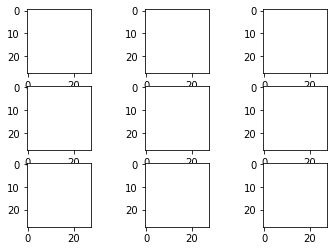

[920/2000]: loss_d: nan, loss_g: nan


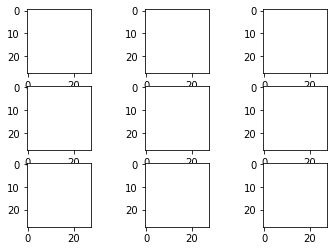

[940/2000]: loss_d: nan, loss_g: nan


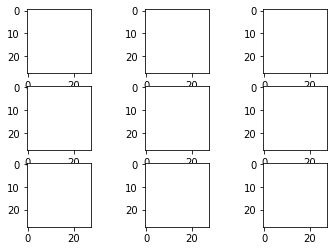

[960/2000]: loss_d: nan, loss_g: nan


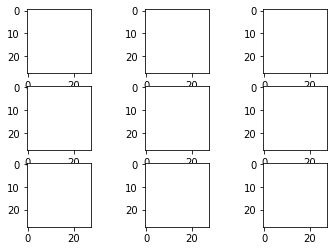

[980/2000]: loss_d: nan, loss_g: nan


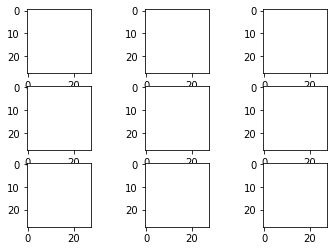

[1000/2000]: loss_d: nan, loss_g: nan


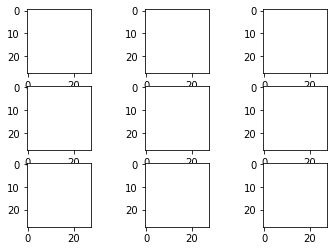

[1020/2000]: loss_d: nan, loss_g: nan


KeyboardInterrupt: 

In [185]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 2000
print_stride = 20

for epoch in range(1, n_epoch+1):           
    RD_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        RD_losses.append(RD_train(x))
        G_losses.append(RD_G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(RD_losses)), torch.mean(torch.FloatTensor(G_losses))))

## Referee (and split referee) Discriminator

In [207]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Referee(nn.Module):
    def __init__(self, r_input_dim):
        super(Referee, self).__init__()
        self.fc1 = nn.Linear(r_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, left, right):
        x = torch.cat((left, right), 1)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, r_dropout)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, r_dropout)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, r_dropout)
        return torch.sigmoid(self.fc4(x))

In [230]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
R = Referee(mnist_dim*2).to(device)

r_dropout = 0.4 #.3

In [231]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
R_optimizer = optim.Adam(R.parameters(), lr = lr)

In [232]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [233]:
R

Referee(
  (fc1): Linear(in_features=1568, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [234]:
# TAKEN FROM ANOTEHR

def R_train(x):
    R.zero_grad()
    
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_f, y_f = G(z), Variable(torch.ones(bs, 1).to(device))

    # train referee on real in 0th index
    x_r, y_r = x.view(-1, mnist_dim), torch.zeros(bs, 1)
    x_r, y_r = Variable(x_r.to(device)), Variable(y_r.to(device))

    R_output = R(x_r, x_f)
    R_real_loss = criterion(R_output, y_r)

    # train referee on real in 1th index
    R_output = R(x_f, x_r)
    R_fake_loss = criterion(R_output, y_f)

    # gradient backprop & optimize ONLY D's parameters
    R_loss = R_real_loss + R_fake_loss
    R_loss.backward()
    R_optimizer.step()
        
    return  R_loss.data.item()

# For paper recreation
def R_G_train(x_r):
    G.zero_grad()
    
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))
    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)
    ones = Variable(torch.ones(bs, 1).to(device))
    
    R_output = R(x_r, x_f) #ref wants this to be 0, g wants this to be 1

    G_loss = criterion(R_output, ones) # G loss low when R_output near 1
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

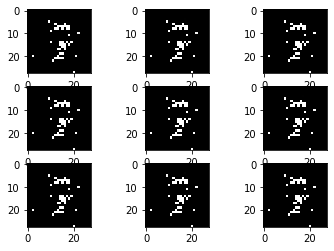

[50/4000]: loss_d: 0.004, loss_g: 0.023


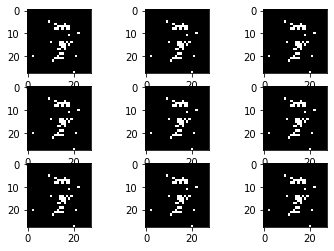

[100/4000]: loss_d: 0.004, loss_g: 0.021


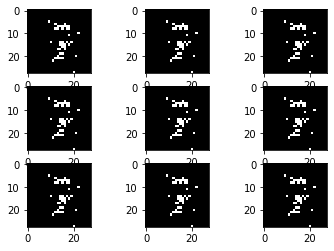

[150/4000]: loss_d: 0.004, loss_g: 0.020


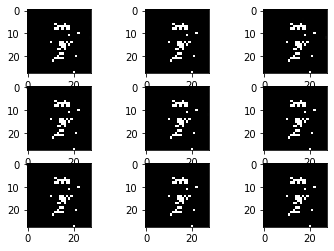

[200/4000]: loss_d: 0.004, loss_g: 0.019


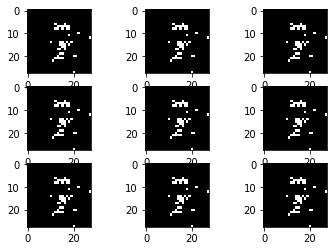

[250/4000]: loss_d: 0.004, loss_g: 0.021


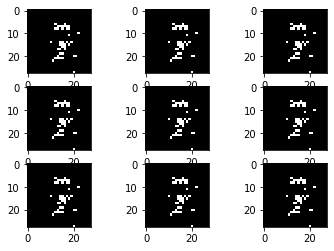

[300/4000]: loss_d: 0.004, loss_g: 0.019


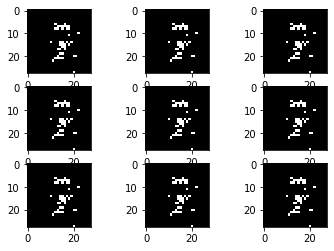

[350/4000]: loss_d: 0.004, loss_g: 0.020


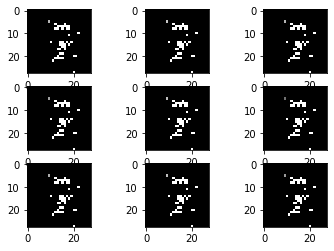

[400/4000]: loss_d: 0.004, loss_g: 0.021


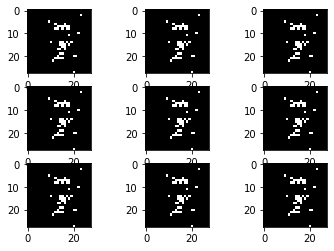

[450/4000]: loss_d: 0.004, loss_g: 0.019


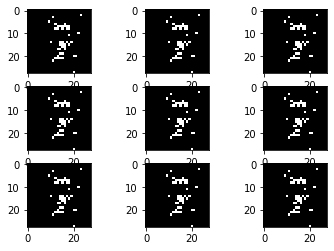

[500/4000]: loss_d: 0.004, loss_g: 0.024


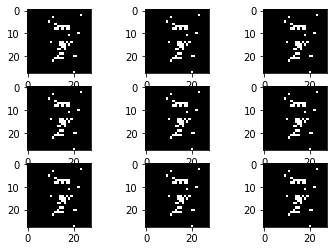

[550/4000]: loss_d: 0.004, loss_g: 0.019


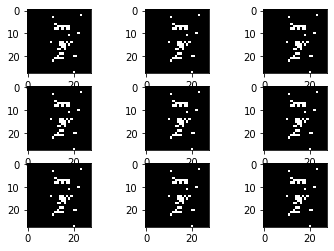

[600/4000]: loss_d: 0.004, loss_g: 0.019


KeyboardInterrupt: 

In [237]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 200
print_stride = 1

for epoch in range(1, n_epoch+1):           
    R_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        R_losses.append(R_train(x))
        G_losses.append(R_G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(R_losses)), torch.mean(torch.FloatTensor(G_losses))))

<IPython.core.display.Javascript object>